# AR-MA

<img src="media/cover.png" style="width: 40%; display: block; margin: auto;">

## Overview 

In this lecture we will cover:
- The autocorrelation function (ACF).
- The partial autocorrelation function (PACF).
- Explanation of how autoregressive and moving average models work.

In [1]:
import sys

# Install dependencies if the notebook is running in Colab
if 'google.colab' in sys.modules:
    !pip install -U -qq tsa-course

In [2]:
# Imports
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
import requests
from io import BytesIO
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import ccf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from tsa_course.lecture2 import run_sequence_plot
np.random.seed(0) # For reproducibility

## Correlations in time series
  - The correlation function measures the degree of association between two random variables.
  - In time series data it measures the association btween two different points in time.
  - Correlation is essential for understanding the linear relationship and dependency in time series data.
  - There are two types of correlation functions: 
      - Autocorrelation.
      - Cross-Correlation.

### Autocorrelation Function (ACF)
  - The ACF measures the correlation of a time series with its own lagged values
  
  $$ ACF(k) = \frac{\mathbb{E}[(X(t) - \mu)(X(t-k) - \mu)]}{\sigma^2} $$ 
  
  - where:
    - $k$ is the lag number.
    - $X(t)$ is the value at time  $t$.
    - $\mu$ is the mean of the series.
    - $\sigma^2$ is the variance of the series.
  - Values close to 1 or -1 indicate strong correlation, while values near 0 indicate weak correlation.

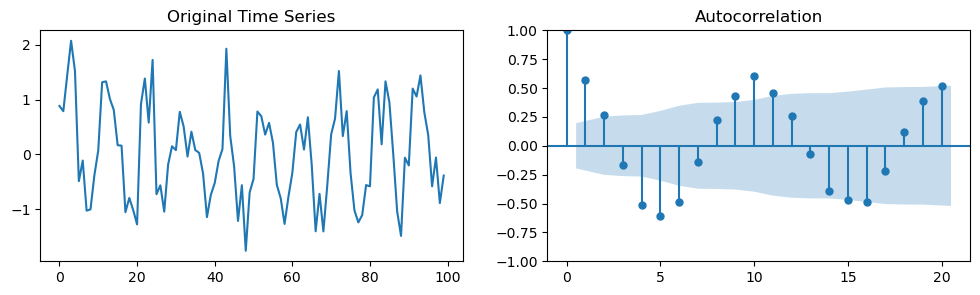

In [3]:
n = 100
time_series_1 = np.random.normal(0, 0.5, n) + np.sin(2*np.pi/10*np.arange(n))
fig, axes = plt.subplots(1, 2, figsize=(12, 3))
axes[0].plot(time_series_1)
axes[0].set_title('Original Time Series')
plot_acf(time_series_1, lags=20, alpha=0.05, ax=axes[1]); # We plot the first 20 lags. We could plot more by changing the `lags` argument.

- The stems represent lagged correlation values. 
- The time series correlates well with itself shifted by 1 (lag 1). 
- A lag of 2 correlates nearly but not quite as well. And so on. 

- The blue region represents a confidence interval. 
- Correlations outside of the confidence interval are statistically significant whereas the others are not. 
- $\alpha$ in this case was 0.05 (95% confidence interval), but it can be set to other levels. 
- See the the [documentation](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html) for more details. 

### Cross-Correlation Function (CCF)

- CCF measures the correlation between two time series at different lags 

$$CCF(k) = \frac{E[(X(t) - \mu_x)(Y(t-k) - \mu_y)]}{\sigma_x \sigma_y}$$ 

- where:
  - $X$ and $Y$ are two different time series.
  - $\mu_x, \mu_y$ are their means, and $\sigma_x, \sigma_y$ are their standard deviations.
- The CCF is commonly used for searching a shorter, known feature, within a long signal.

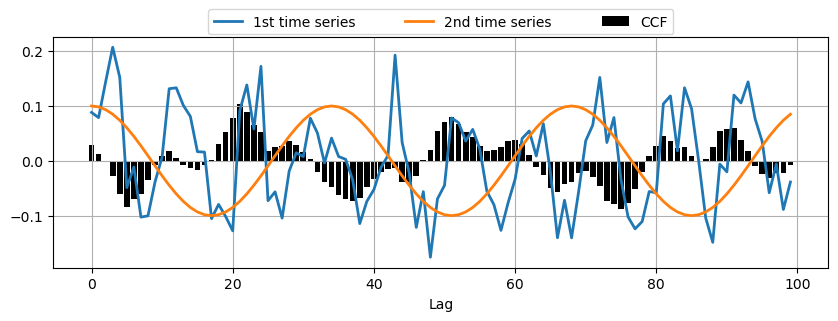

In [4]:
time_series_2 = np.cos(np.pi/17*np.arange(n))

# Calculate CCF between the two time series
ccf_vals = ccf(time_series_1, time_series_2, adjusted=False)

# Plot CCF
_, ax = plt.subplots(1,1,figsize=(10,3))
ax.bar(range(len(ccf_vals)), ccf_vals, color='k', label='CCF')
ax.plot(time_series_1*0.1, linewidth=2, label='1st time series')
ax.plot(time_series_2*0.1, linewidth=2, label='2nd time series')
plt.xlabel('Lag')
plt.legend(bbox_to_anchor=(0.2, 1.01, .6, 1.5), loc='lower center', ncol=3, mode="expand", borderaxespad=0.)
plt.grid();

### Practical Applications of Correlation Functions
  - Identifying the nature of the data (e.g., whether it is random, has a trend or a seasonality).
  - Helping to determine the order of ARIMA models (more on this later on).
  - Identifying outliers in time series data.

### Limitations and Considerations
1. Correlation functions only measure *linear* relationships.
2. For meaningful results, time series should be *stationary*.
3. High correlation does not imply *causation* and can sometimes be misleading.
     
<img src="media/timoelliot.png" style="width: 25%; display: block; margin: auto;">

<div style="text-align: center; font-size: 15px;">Image: <a href="https://timoelliott.com/">timoelliot</a></div>

4. ACF measures both direct and *indirect correlations* between lags. 
    - A strong correlation at higher lags could be a result of the accumulation of correlations at shorter lags.

- Consider for example a random walk
$$X(t)=X(t-1)+\epsilon_t$$
- You may think that only lag $h=1$ is important, but...

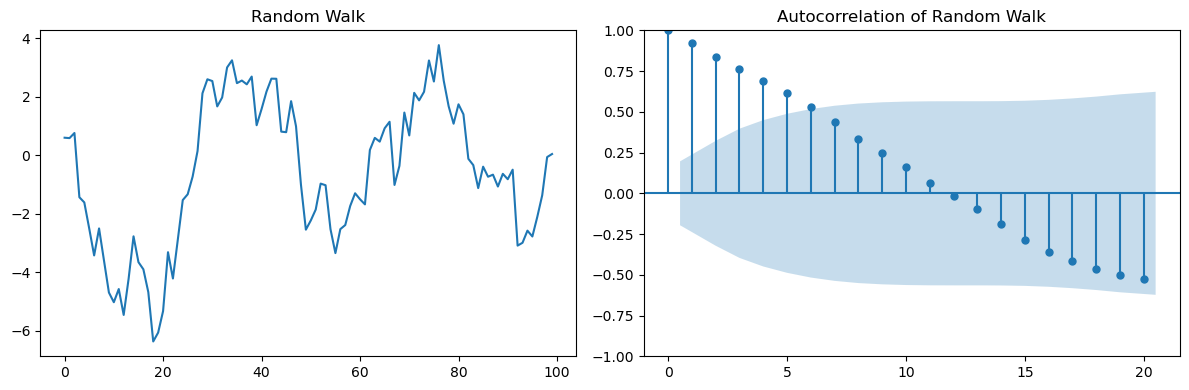

In [46]:
random_walk = np.cumsum(np.random.normal(0, 1, 100))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(random_walk)
axes[0].set_title('Random Walk')
plot_acf(random_walk, lags=20, alpha=0.05, ax=axes[1])
axes[1].set_title('Autocorrelation of Random Walk')
plt.tight_layout()

- You can see that lags $h>1$ are also present in the ACF
- Those are indirect correlations due to the accumulation of the main correlation at lag $h=1$

### The Partial Autocorrelation Function (PACF)

- PACF addresses the 4th limitation of ACF by isolating the direct correlation between a time series and its lagged version.
- It does that by removing the influence of correlations at shorter lags.
- High PACF at lag $k$ indicates a strong partial correlation with the $k$-th lag, not accounted for by correlations at lower lags.


- PACF of lag $k$ is sometimes denoted as $\phi_{kk}$: 

$$\phi_{kk} = \text{Corr}\big(X(t) - \hat{X}(t), X(t-k) - \hat{X}(t-k)\big)$$ 

- where:
    - $\hat{X}(t)$ is the predicted value of $X(t)$ based on all the values up to $t-1$.
    - $\hat{X}(t-k)$ is the predicted value of $X(t-k)$ based on all the values up to $t-k-1$.

- Using ACF and PACF together provides a more comprehensive understanding of the time series data.
- ACF helps in identifying the overall correlation structure and potential seasonality.
- PACF pinpoints the specific lags that have a significant direct impact on the current value.

**Example**

- Consider a time series where ACF shows significant correlation at lags 1, 2, and 3. 
- Without PACF, it is unclear whether the correlation at lag 3 is direct or merely a reflection of the strong correlations at lags 1 and 2. 
- PACF can clarify this by showing whether there is a significant direct correlation at lag 3.

In [48]:
n = 100
time_series = np.zeros(n)
alpha1, alpha2, alpha3 = 0.6, -0.3, 0.2  # Coefficients to induce autocorrelation at lags 1, 2, and 3
noise = np.random.normal(0, 1, n)

# Generate correlated data
for t in range(3, n):
    time_series[t] = alpha1 * time_series[t-1] + alpha2 * time_series[t-2] + alpha3 * time_series[t-3] + noise[t]

<Axes: title={'center': 'Time Series with Autocorrelation'}, xlabel='Time', ylabel='Values'>

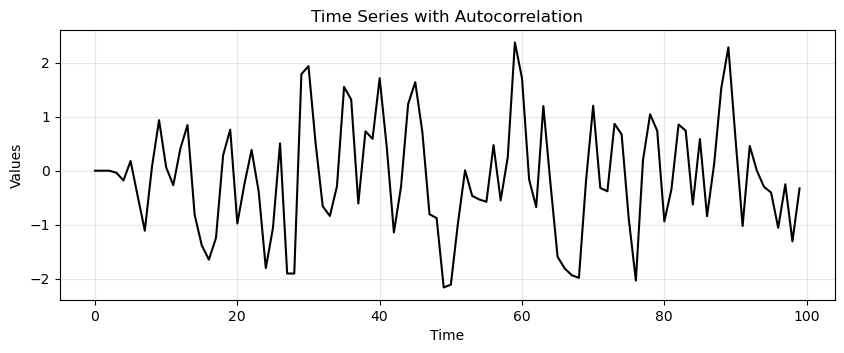

In [49]:
run_sequence_plot(np.arange(100), time_series, title='Time Series with Autocorrelation')

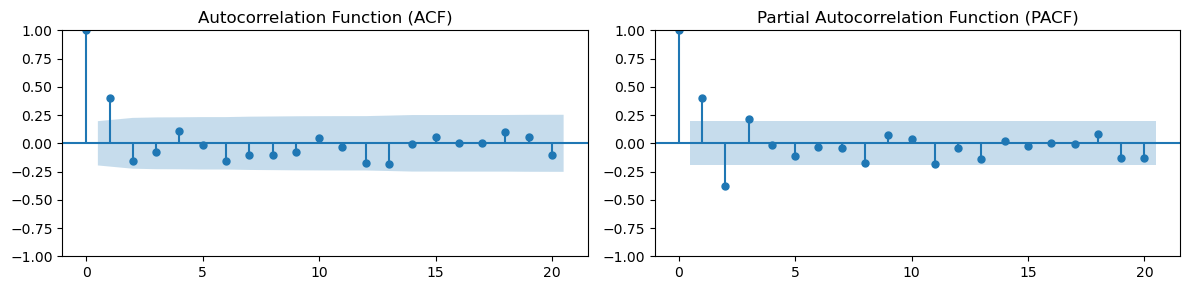

In [50]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

# Plot ACF
plot_acf(time_series, ax=ax1)
ax1.set_title('Autocorrelation Function (ACF)')

# Plot PACF
plot_pacf(time_series, ax=ax2)
ax2.set_title('Partial Autocorrelation Function (PACF)')
plt.tight_layout()

- Lag estimation with ACF and PACF is helpful in modelling time-series with autoregressive and moving-average models that we'll introduce in the next sections.
  
---

## Autoregressive (AR) models

  - An Autoregressive (AR) model is a type of time series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step.
  - The AR model is dependent solely on its own past values.
  

- The general form of an AR model of order $p$ is: 

$$X(t) = c + \phi_1 X(t-1) + \phi_2 X(t-2) + \dots + \phi_p X(t-p) + \epsilon_t$$ 

- where
    - $X(t)$: Time series value at time $t$.
    - $c$: Constant term (also known as the intercept).
    - $\phi_1, \phi_2, \dots, \phi_p$: Coefficients of the model.
    - $p$: Order of the AR model (number of lag terms).
    - $\epsilon_t$: Error term (white noise) at time $t$.

**AR(1) Model** 
- The first-frder autoregressive model, AR(1), is 

$$X(t) = c + \phi_1 X(t-1) + \epsilon_t$$

- In an AR(1) model, the current value is based on the immediately preceding value.
> Example: A simple stock price model where today's price is partially dependent on yesterday's price.

**Higher Order AR Models**
- Higher order AR models (AR(2), AR(3), etc.) depend on more than one past value.
- For example, the AR(2) model is: 

$$X(t) = c + \phi_1 X(t-1) + \phi_2 X(t-2) + \epsilon_t$$

- These models are useful in scenarios where the effect of more than one previous time step is significant.

**Estimating AR Model Coefficients**
- Coefficients of AR models can be estimated using various methods like the Maximum Likelihood Estimation, or Least Squares Estimation.
- The estimated coefficients provide insights into the influence of past values on the current value in the time series.
- In other words, AR models are *interpretable*.

**Limitations of AR Models**
- AR models require the time series to be *stationary*.
- Higher order AR models can *overfit* the training data and perform bad in prediction.
- They cannot model non-linear relationships in the data.

- Natively, the AR models do not account for *exogenous factors*.
- These, usually are additional time series that are relevant for the prediction.
- For example, the time series of the temperatures when predicting the electricity load.
- There are extensions (ARMAX) that allow to include exogenous variables in the model.

### AR model identification

- How do we determine the correct order $p$ of the AR model?
- We do that by looking at the first lags of the PACF.
- Let's see it through an example.

- We generate some data from an AR(2) process with coefficients `[1.0, -0.5, 0.7]`.
- Note that the `1.0` at the beginning refers to the zero-lag and is always `1.0`.

In [7]:
ar_data = arma_generate_sample(ar=np.array([1.0, -0.5, 0.7]), ma=np.array([1]), nsample=200, scale=1, burnin=1000)

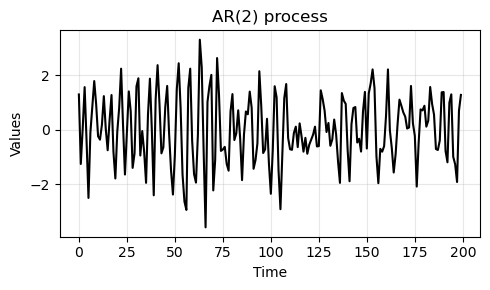

In [8]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
run_sequence_plot(np.arange(200), ar_data, ax=ax, title="AR(2) process")
plt.tight_layout()

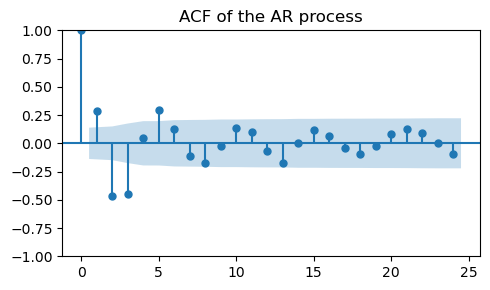

In [9]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_acf(ar_data, ax=ax, title="ACF of the AR process")
plt.tight_layout();

- Next, we compute the PACF on the `ar_data`.

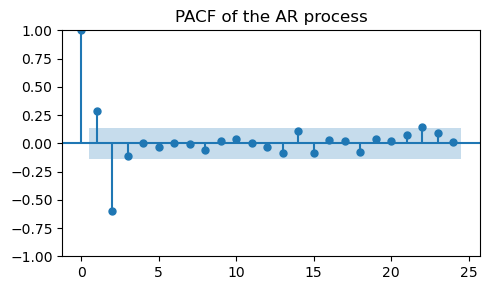

In [10]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_pacf(ar_data, ax=ax, title="PACF of the AR process")
plt.tight_layout();

- Besides the spike at lag 0, which is always there, we see two significant lags:
    - The *positive* spike at lag 1, introduced by the *negative* coefficient `0.5`.
    - The *negative* spike at lag 2, introduced by the *positive* coefficient `0.7`.

- This means that the process has a *memory* of length 2.
- In other words, (most of) the correlations in the data are explained by the previous 2 time steps.
- If we want to fit an AR model to our data we would choose $p=2$, which is a AR(2) model.

- Finally, an AR process is characterized by correlations that decay slowly in time.
- This can be seen by looking at the ACF plot, where we see significant spikes over many lags.

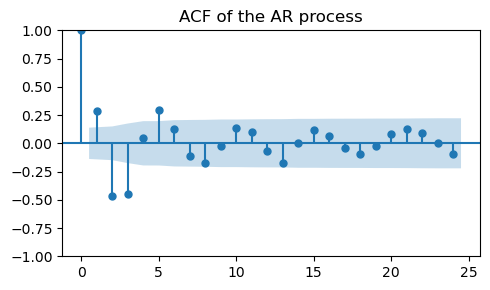

In [11]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_acf(ar_data, ax=ax, title="ACF of the AR process")
plt.tight_layout()

**⚙ Try it yourself**

- Try modifying/adding/removing values in the `ar` coefficients in `arma_generate_sample`.
- Then, see how the PACF plot changes.

### Forecasting with AR models

- How do we compute forecasts using an AR model?
- In general, our time series has a trend and a seasonality.
- However, an AR model can only be used on *stationary* data.
- Therefore, we need to do the following steps.

#### Step 1: Remove trend and seasonality
- Before applying an AR model is necessary to make the time series stationary.
- This can be done using techniques we saw in the previous chapters.
- Two possibile ways of doing it are:
    1. Apply standard and seasonal differencing to the time series.

    $$
    \begin{aligned}
    R'(t) = X(t + 1) - X(t) & \qquad \text{removes trend} \\
    R(t) = R'(t + L) - R'(t) & \qquad \text{removes seasonality}
    \end{aligned}
    $$

    2. Estimate trend $T$ and seasonality $S$ (e.g., by using seasonal decomposition or smoothing techniques) and subtract them: 
    
    $$R(t) = X(t) - T(t) - S(t)$$

#### Step 2: Apply the AR model

- Identify the order of the AR model.
- Fit an AR model to the detrended and deseasonalized time series $R(t)$.
- Use the model to forecast the next values $\hat R(t+\tau), \tau=1, \dots, H$ where $H$ is the forecast horizon.

#### Step 3: Reconstruct the forecast

- The reconstruction procedure depends on how we made the time series stationary at step 1.
- If we used differencing:
    - We must undo the differentiation by taking cumulative sums of the residuals.
- If we modelled and removed trend and seasonality, for each $\tau \in [1, H]$:
    - Predict the trend $\hat{T}(t+\tau)$ and the seasonal component $\hat{S}(t+\tau)$.
    - Add back the estimated trend and seasonality to the forecasted value: 

    $$\hat X(t+\tau) = \hat R(t+\tau) + \hat{T}(t+\tau) + \hat{S}(t+\tau)$$


### Example: forecasting with AR model

- Let's generate some data with trend and seasonality.

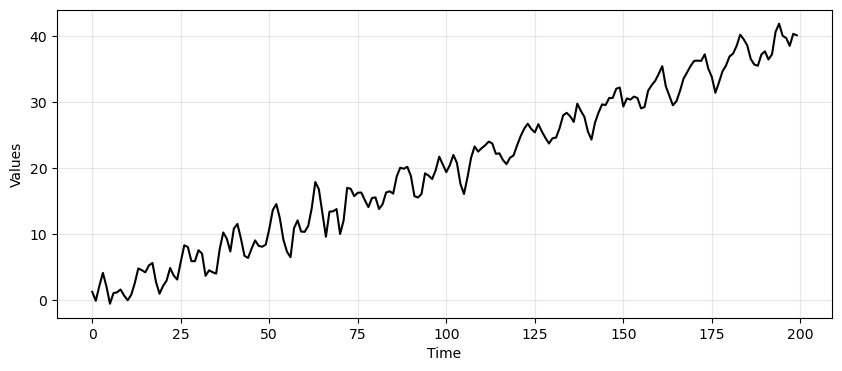

In [12]:
time = np.arange(200)
trend = time * 0.2
seasonality = 2*np.sin(2*np.pi*time/12) # Seasonality 12
time_series_ar = trend + seasonality + ar_data

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time, time_series_ar, "", ax=ax);

- Since we are going to compute forecasts, let's divide the data in a train and test set.

In [13]:
train_data_ar = time_series_ar[:164]
test_data_ar = time_series_ar[164:]

- To determine the order $p$ of the AR model we need to look at the PACF.
- The order $p$ corresponds to the least nonzero lag in the PACF plot.

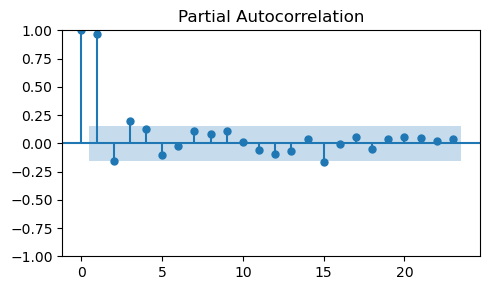

In [14]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_pacf(train_data_ar, ax=ax)
plt.tight_layout();

- The PACF would suggest an order $p=1$.
- However, this PACF *makes little sense*.
- As we discussed before, both the ACF and PACF should be computed on stationary data.
- If data are stationary, correlations drop quickly. 
- If they don't, that's a sign that your data is not stationary.

- Since we generated the time series by hand we know that it has trend and seasonality and, therefore, it is not stationary.
- However, to be rigorous we'll test the time series with the Augmented Dickey-Fuller (ADF) test. 

In [15]:
_, pvalue, _, _, _, _ = adfuller(train_data_ar)
print(f"p-value: {pvalue:.3f}")

p-value: 0.985


- A p-value that high means we *fail* to reject the null hypothesis

 $$H_0: \text{the data is nonstationary}$$

- No surprises here.

- To achieve stationarity we can transform the data by applying one of the techniques discussed in [step 1](#step-1-remove-trend-and-seasonality).
- Let's first try with differencing.

#### Stationairty through differencing

- We start by applying 1st-order differencing to remove the trend.
- Then, we check the stationarity of the differenced data with the ADF test.

In [16]:
diff_ar = train_data_ar[1:] - train_data_ar[:-1]

_, pvalue, _, _, _, _ = adfuller(diff_ar)
print(f"p-value: {pvalue:.3f}")

p-value: 0.000


- The ADF test suggests that now the time series is stationary.
- We might want to apply also *seasonal differentiation* to get rid of the seasonal component.
- However, differencing too many times might compromise the structure of the data.
- This problem is called *overdifferencing*.
- See [this explanation](https://people.duke.edu/~rnau/411arim2.htm) for how to determine the optimal order of differentiation.

- Let's see how data looks like after 1st-oder differencing.

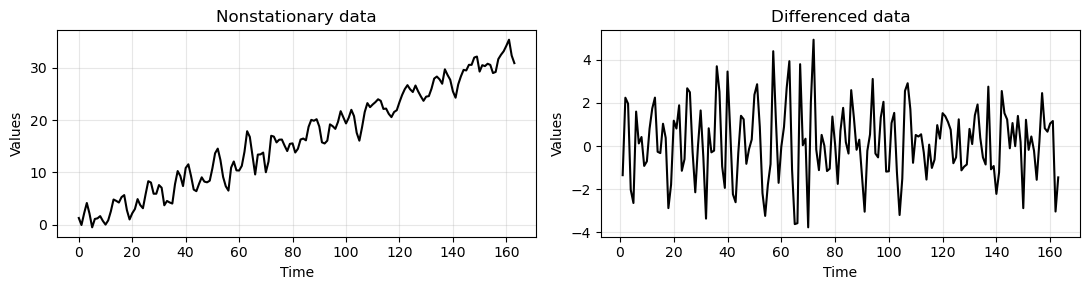

In [17]:
_, axes = plt.subplots(1,2, figsize=(11,3))
run_sequence_plot(time[:len(train_data_ar)], train_data_ar, title="Nonstationary data", ax=axes[0])
run_sequence_plot(time[1:len(train_data_ar)], diff_ar, title="Differenced data", ax=axes[1])
plt.tight_layout();

- Let's recompute the PACF on the differenced data.
- We also compare it to the PACF on the original `ar_data` and the nonstationary data `train_data_ar`.

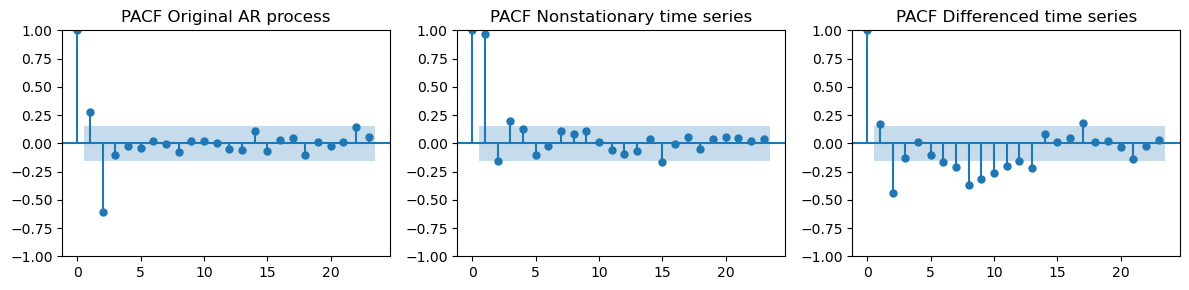

In [18]:
_, axes = plt.subplots(1, 3, figsize=(12, 3))
plot_pacf(ar_data[:len(train_data_ar)], ax=axes[0], title="PACF Original AR process")
plot_pacf(train_data_ar, ax=axes[1], title="PACF Nonstationary time series")
plot_pacf(diff_ar, ax=axes[2], title="PACF Differenced time series")
plt.tight_layout();

- The prominent negative spike at lag 2 appears both in the PACF of the original AR data and in the differenced time series.
- These two look way more similar than the PACF we got for the nonstationary data.
- The prominent spike at lag 2 suggests that $p=2$, i.e., we should use an AR(2) model.

**⚠ Attention**

- In the differenced time series there are also other significant spikes at higher lags, which are not present in the original AR data.
- This is because there is a seasonal component left in the data.
- Let's see if we can remove them by applying seasonal differencing and recompute the PACF plot.

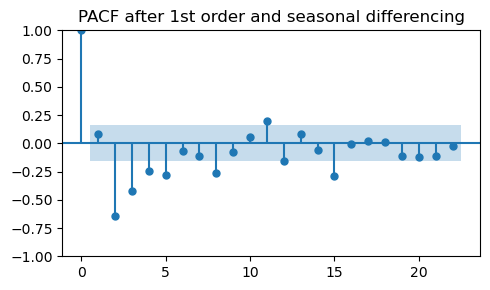

In [19]:
# Seasonal differencing
diff_diff_ar = diff_ar[12:] - diff_ar[:-12]

_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_pacf(diff_diff_ar, ax=ax, title="PACF after 1st order and seasonal differencing")
plt.tight_layout();

- Even after seasonal differencing we are not able to recover the PACF of the original data.
- On the contrary, this PACF looks even more different than the original one.
- In practice, it is rare to get a "clean" PACF with only one prominent lag at the correct order when using differencing.
- Interpreting the PACF (and ACF) plots to select the order of the model requires skills and experience.
- See [this explanation](https://people.duke.edu/~rnau/411arim3.htm) for how to select the order of the AR and MA models.

**📝 Note**

- Besides overdifferencing, other issues appear when stationarity is achieved with differencing.
- Some data are lost at the beginning or at the end of the time series due to differencing.
    - For example, when applying 1st order and seasonal differencing $L+1$ steps are lost.
- In addition, it is easy to make mistakes when reverting the differencing to make predictions.
- This further complicates when there is a gap between the training and test set or when the forecast horizon $H$ goes beyond the seasonality $L$.

#### Stationarity by subtracting estimated trend and seasonality

- We could estimate the trend and seasonality with Triple exponential smoothing (TES).
- Then, we compute the residuals subtracting the estimated trend and seasonality.
- We see that, in this case, the residuals are much closer to our original AR process.

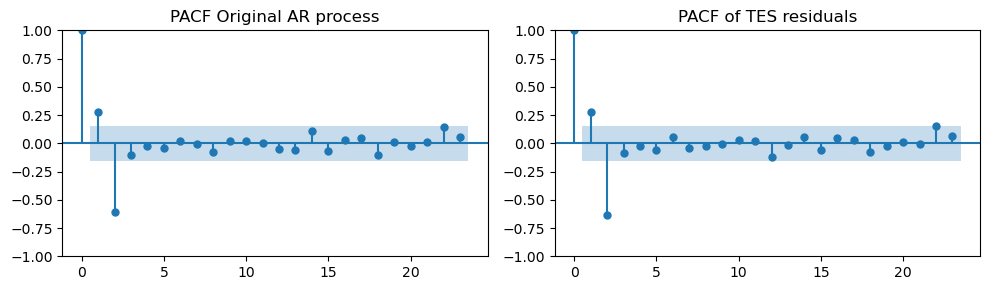

In [20]:
tes = ExponentialSmoothing(train_data_ar, trend='add',
                           seasonal='add', seasonal_periods=12).fit()
trend_and_seasonality = tes.fittedvalues # Estimated trend and seasonality
tes_resid = train_data_ar - trend_and_seasonality

_, axes = plt.subplots(1, 2, figsize=(10, 3))
plot_pacf(ar_data[:len(train_data_ar)], ax=axes[0], title="PACF Original AR process")
plot_pacf(tes_resid, ax=axes[1], title="PACF of TES residuals")
plt.tight_layout();

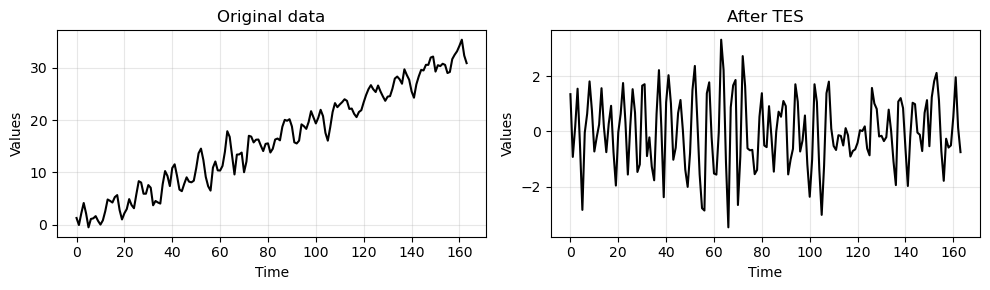

In [21]:
_, ax = plt.subplots(1, 2, figsize=(10, 3))
run_sequence_plot(time[:len(train_data_ar)], train_data_ar, title="Original data", ax=ax[0])
run_sequence_plot(time[:len(train_data_ar)], tes_resid, title="After TES", ax=ax[1])
plt.tight_layout()

**💡 Hint**

- In this case, we knew the main period to be `12`.
- In general, we need to estimate it.
- We can use the `fft_analysis` function from Lecture 1.

In [22]:
from tsa_course.lecture1 import fft_analysis

period, _, _ =fft_analysis(time_series_ar)
print(f"Period: {np.round(period)}")

Period: 12.0


**⚠ Attention**

- Smoothers work so well here because we use toy data with additive components, linear trend, constant variance, etc...
- Many real-world data do not look so nice.
- In some cases, we have to rely on other techniques, including differentiation and the "dirty" ACF/PACF plot we got from it.

### Forecasting with AR model

- Once the data are stationary, we are ready to fit the AR(2) model.
- Depending on which method we used to obtain stationary data, we must do something different to reconstruct the predictions.
- Let's start with the stationary data obtained from differencing.

**Differencing approach**

- First, we use `diff_diff_ar` to fit an AR(2) model and make forecasts for a period as long as the test data.
- Note how after a short while the forecast goes to zero.
- This, indicates that the AR(2) model is very uncertain about long-terms forecasts. 

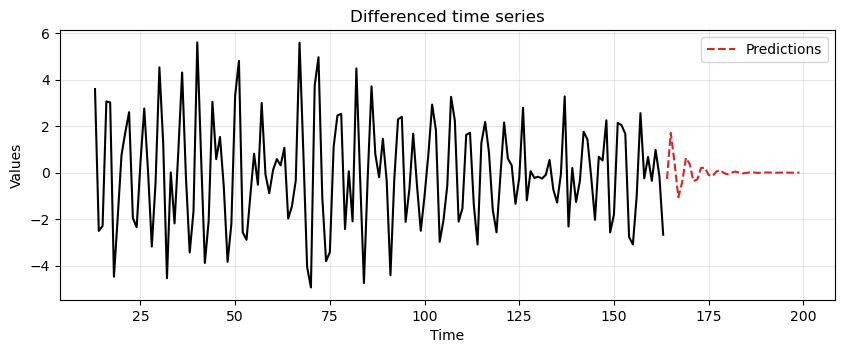

In [23]:
# Fit the model
model = ARIMA(diff_diff_ar, order=(2,0,0))
model_fit = model.fit()

# Compute predictions
diff_preds = model_fit.forecast(steps=len(test_data_ar))

ax = run_sequence_plot(time[13:len(train_data_ar)], diff_diff_ar, "")
ax.plot(time[len(train_data_ar):], diff_preds, label='Predictions', linestyle='--', color='tab:red')
plt.title('Differenced time series')
plt.legend();

- To obtain the final predictions we must first revert the seasonal differencing and then the 1st-order differencing. 

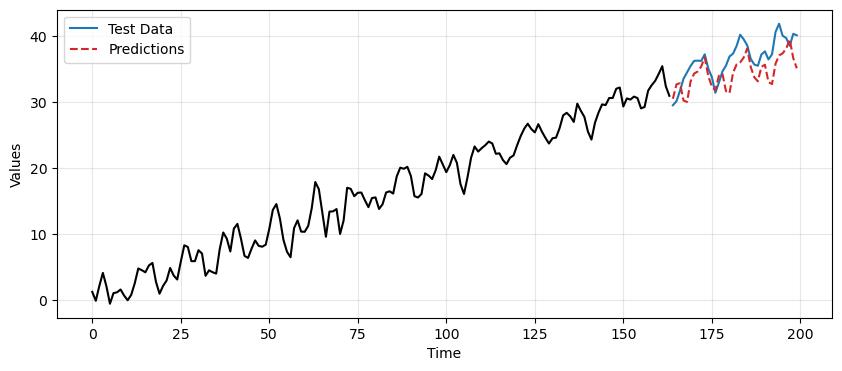

In [24]:
# Reintegrating the seasonal differencing
reintegrated_seasonal = np.zeros(len(test_data_ar))
reintegrated_seasonal[:12] = diff_ar[-12:] + diff_preds[:12]
for i in range(12, len(test_data_ar)):
    reintegrated_seasonal[i] = reintegrated_seasonal[i-12] + diff_preds[i]

# Reintegrating 1st order differencing
reintegrated = reintegrated_seasonal.cumsum() + train_data_ar[-1]

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time[:len(train_data_ar)], train_data_ar, "", ax=ax)
ax.plot(time[len(train_data_ar):], test_data_ar, label='Test Data', color='tab:blue')
ax.plot(time[len(train_data_ar):], reintegrated, label='Predictions', linestyle='--', color='tab:red')
plt.legend();

**⚠ Attention**

- It's very easy to make errors with indices when reverting the differencing operations.
- Also, the previous operations assume that there are no gaps between train and test data.

**TES-based approach**

- Next, we consider the stationary data obtained by subtracting the trend and seasonality estimated with TES.
- This time we use `tes_resid` to fit the AR(2) model and make forecasts.

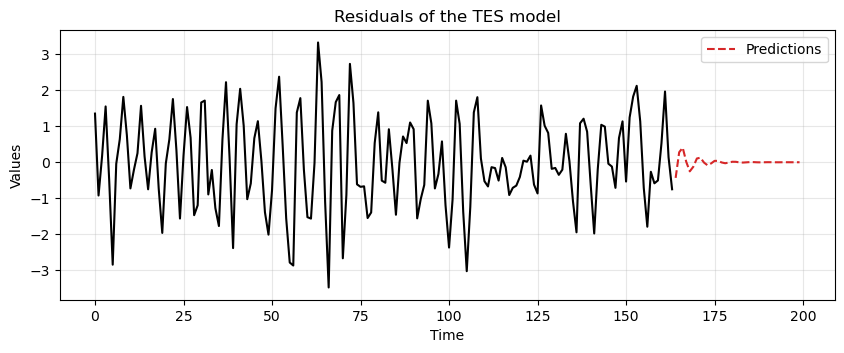

In [25]:
model = ARIMA(tes_resid, order=(2,0,0))
model_fit = model.fit()

resid_preds = model_fit.forecast(steps=len(test_data_ar))

ax = run_sequence_plot(time[:len(train_data_ar)], tes_resid, "")
ax.plot(time[len(train_data_ar):], resid_preds, label='Predictions', linestyle='--', color='tab:red')
plt.title('Residuals of the TES model')
plt.legend();

- Then, we add back the trend and the seasonality to the predictions.
- To do that, we first generate predictions for trend and seasonal components using TES.
- Finally, we sum all the predictions to obtain the final result. 

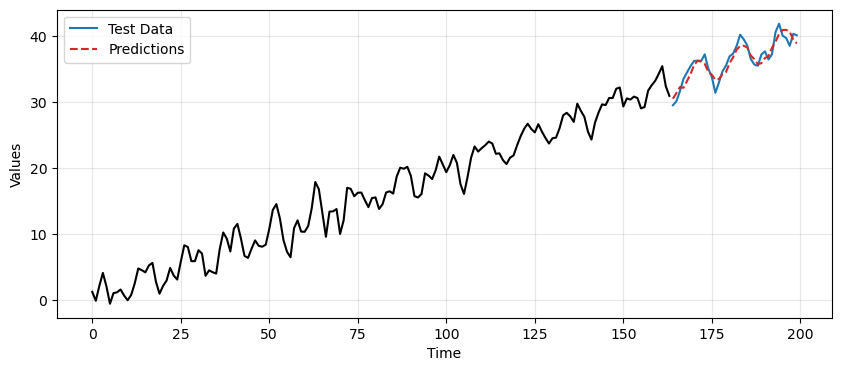

In [26]:
# Add back trend and seasonality to the predictions
tes_pred = tes.forecast(len(test_data_ar))
final_preds = tes_pred + resid_preds

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time[:len(train_data_ar)], train_data_ar, "", ax=ax)
ax.plot(time[len(train_data_ar):], test_data_ar, label='Test Data', color='tab:blue')
ax.plot(time[len(train_data_ar):], final_preds, label='Predictions', linestyle='--', color='tab:red')
plt.legend();

- In this case we obtain better predictions using the TES-based approach compared to differencing.
- We can quantify the difference in performance by computing the MSE.

In [27]:
mse_differencing = mean_squared_error(test_data_ar, reintegrated)
mse_tes = mean_squared_error(test_data_ar, final_preds)

print(f"MSE of differencing: {mse_differencing:.2f}")
print(f"MSE of TES: {mse_tes:.2f}")

MSE of differencing: 8.03
MSE of TES: 1.12


---

## Moving Average (MA) models

- Another approach to modeling univariate time series is the moving average (MA) model.
- The MA model is a linear regression of the current value of the series against the white noise of one or more of the previous values of the series.
- The noise at each point is assumed to come from a normal distribution with mean 0 and constant variance.

- The MA model is defined as 

$$X(t) = \mu + \epsilon_t + \theta_1 \epsilon_{t-1} + \theta_2 \epsilon_{t-2} + \dots + \theta_q \epsilon_{t-q}$$ 

- where:
    - $X(t)$: Time series value at time $t$.
    - $\mu$: Mean of the series.
    - $\theta_1, \theta_2, \dots, \theta_q$: Coefficients of the model.
    - $q$: Order of the MA model (number of lagged error terms).
    - $\epsilon_t$: Error term (white noise) at time $t$.

- MA models capture the dependency between an observation and a residual error through a moving average applied to lagged observations.
- Fitting MA estimates is more complicated than AR models because the error terms are not observable.
- Therefore, iterative nonlinear fitting procedures need to be used.
- MA models are less interpretable than AR models.
- As AR models, also MA models require data to be stationary.

**⚠ Attention**
- We talked about smoothing with a moving averages in Lesson 3.
- MA models are not the same as those smoothing techniques.
- Each serves a different, important function.
- We should not confuse the two.

### MA model identification

- Before, for the [AR model identification](#ar-model-identification), we selected $p$ as the lag after which the spikes in the PACF become nonsignificant.
- To identify the order $q$ of the MA model we do the same but we use the ACF plot insted.
- Let's see it through an example.

- We generate some data from an MA(2) process with coefficients `[1.0, 0.7, 0.8]`.
- Again, the `1.0` at the beginning refers to the zero-lag.

In [28]:
ma = np.array([1.0, 0.7, 0.8])  # MA parameters
ma_data = arma_generate_sample(np.array([1]), ma, nsample=len(time), scale=1, burnin=1000) # MA process

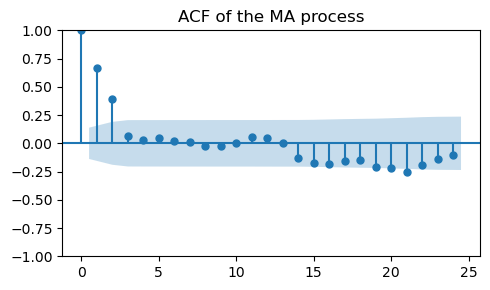

In [29]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_acf(ma_data, ax=ax, title="ACF of the MA process")
plt.tight_layout();

- As expected, there is a cutoff after the second lag.
- This indicates that the order of the MA model is $q=2$

- Characteristic of an MA process are the slowly decaying, alternative spikes in the PACF plot.
- Note how this is complementary to what we saw for the [AR process](#ar-model-identification).

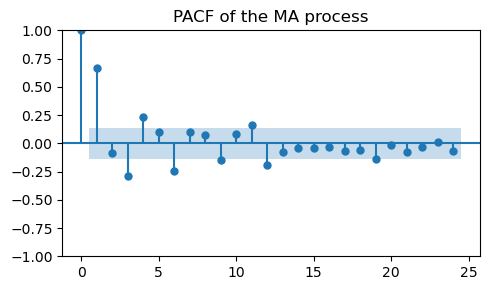

In [30]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_pacf(ma_data, ax=ax, title="PACF of the MA process")
plt.tight_layout();

**⚙ Try it yourself**

- Try modifying/adding/removing values in the `ma` coefficients in `arma_generate_sample`.
- Then, see how the ACF plot changes.

### Example: forecasting with MA model

- We repeat the same procedure as in the [AR example](#example-forecasting-with-ar-model) with a MA model.
- The only difference is that now we construct a time series using a MA process rather than an AR one.

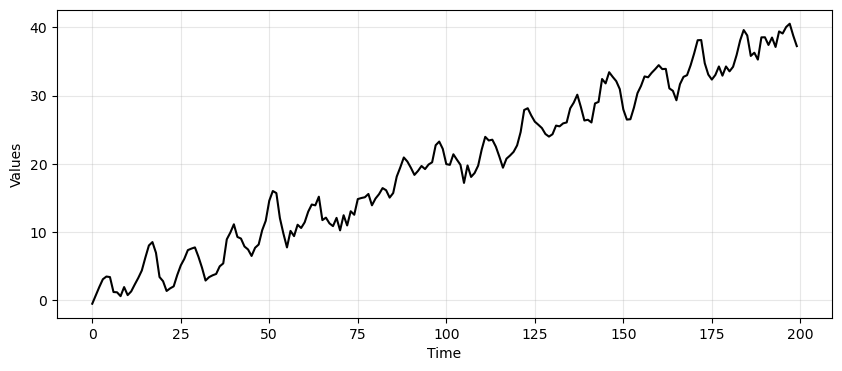

In [31]:
time_series_ma = trend + seasonality + ma_data

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time, time_series_ma, "", ax=ax);

In [32]:
# Train/test split
train_data_ma = time_series_ma[:164]
test_data_ma = time_series_ma[164:]

- To identify the order $q$ of the MA model we must look at the ACF plot.
- Let's start by computing the ACF of `train_data_ma`, which looks very different from the ACF plot we obtained [before](#ma-model-identification) for the MA process.

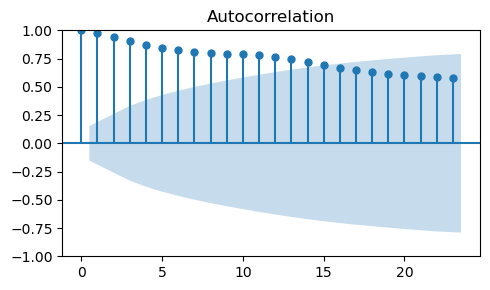

In [33]:
_, ax = plt.subplots(1, 1, figsize=(5, 3))
plot_acf(train_data_ma, ax=ax)
plt.tight_layout();

- Also in this case, we need to make the time series stationary to obtain a meaningful ACF plot.
- Like in the AR case, stationarity is needed to correctly estimate the MA coefficients.

#### Stationairty through differencing

- Like we did in the AR example, we will try to obtain stationaity through differencing.


In [34]:
diff_ma = train_data_ma[1:] - train_data_ma[:-1]

- To verify that our data are stationary, we compute the ADF test before and after differentiation.

In [35]:
_, pvalue_ts, _, _, _, _ = adfuller(train_data_ma)
_, pvalue_diff, _, _, _, _ = adfuller(diff_ma)
print(f"p-value (original ts): {pvalue_ts:.3f}")
print(f"p-value (differenced ts): {pvalue_diff:.3f}")

p-value (original ts): 0.959
p-value (differenced ts): 0.000


- We also plot the differenced data and compute the ACF.

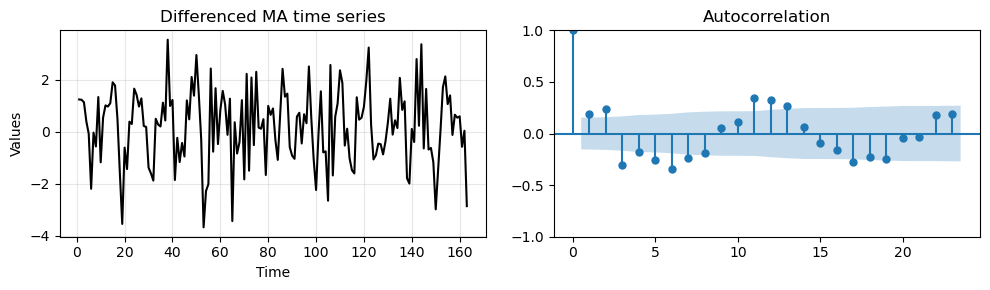

In [36]:
_, axes = plt.subplots(1,2, figsize=(10, 3))
run_sequence_plot(time[1:len(train_data_ma)], diff_ma, "Differenced MA time series", ax=axes[0])
plot_acf(diff_ma, ax=axes[1])
plt.tight_layout();

- Like in the previous case, we have significant correlations at higher lags due to the seasonal component.
- For comparison, we compute the ACF of:
    - the original AR process, 
    - the time series after 1st order differencing,
    - the time series with both 1st order + seasonal differening.

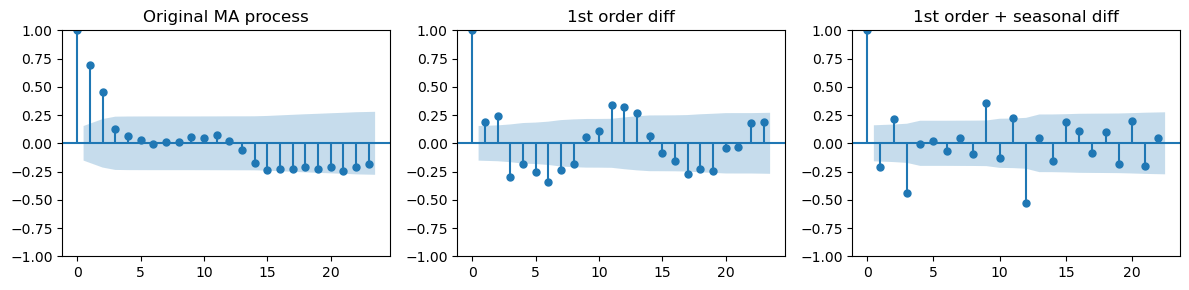

In [37]:
diff_diff_ma = diff_ma[12:] - diff_ma[:-12]

_, axes = plt.subplots(1,3, figsize=(12, 3))
plot_acf(ma_data[:len(train_data_ma)], ax=axes[0], title="Original MA process")
plot_acf(diff_ma, ax=axes[1], title="1st order diff")
plot_acf(diff_diff_ma, ax=axes[2], title="1st order + seasonal diff")
plt.tight_layout();

- When taking both differencing the ACF plot looks very different.
- The positive correlations at lags 1 and 2 are gone and a the first non-zero correlation appears at lag 3.
- Like we saw in the AR case, this hints at an overdifferencing.

- In conclusion, is not obvious which MA model to use from the analysis of the ACF plots.
- The ACF after 1st order differencing suggests using order $p=1$ or $p=2$.
- The ACF obtained after seasonal differencing suggests order $p=3$, but we suspect overdifferencing.

#### Stationarity by subtracting estimated trend and seasonality

- In the following we repeat the same procedure to estimate trend and seasonality with TES.
- Since the MA process is more "noisy" that the AR process, we increase the level of smoothing by setting $\alpha=0.01$.
- As shown in the plot below, this leads to a smoother estimate of the trend and seasonality.

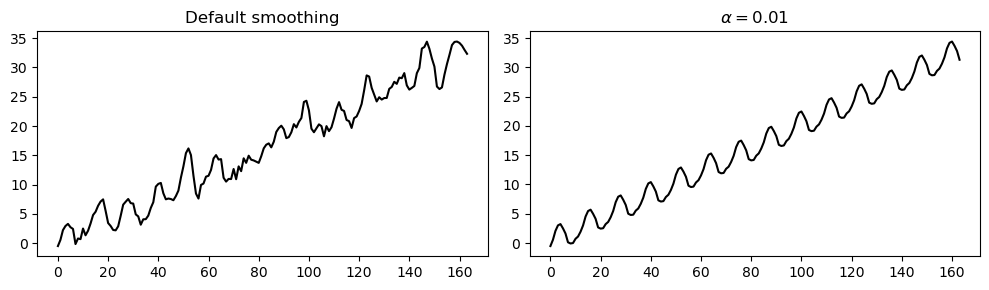

In [38]:
period, _, _ =fft_analysis(time_series_ma) 
period = np.round(period).astype(int)

tes_ma_default = ExponentialSmoothing(train_data_ma, trend='add',
                           seasonal='add', seasonal_periods=period).fit(smoothing_level=None)
tes_ma = ExponentialSmoothing(train_data_ma, trend='add',
                           seasonal='add', seasonal_periods=period).fit(smoothing_level=0.01)
trend_and_seasonality_default = tes_ma_default.fittedvalues 
trend_and_seasonality = tes_ma.fittedvalues 

_, axes = plt.subplots(1, 2, figsize=(10, 3))
axes[0].plot(trend_and_seasonality_default, 'k')
axes[0].set_title('Default smoothing')
axes[1].plot(trend_and_seasonality, 'k')
axes[1].set_title('$\\alpha=0.01$')
plt.tight_layout();

- Next, we compute the residuals subtracting the estimated trend and seasonality.
- The ACF plots of the original MA process and the residuals are very similar.
- This indicates that we have correctly removed trend and seasonality.

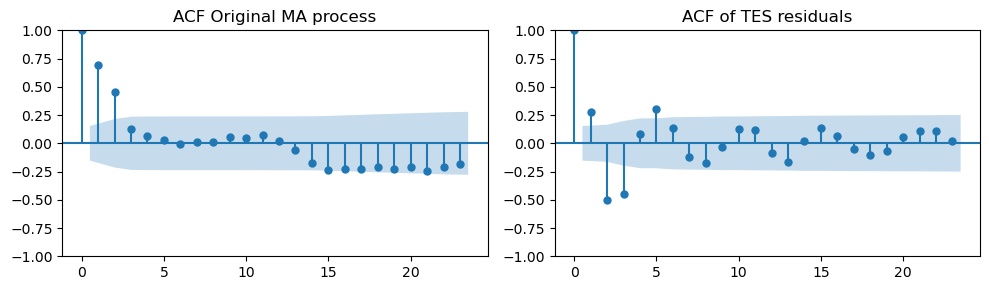

In [39]:
tes_resid_ma = train_data_ma - trend_and_seasonality

_, axes = plt.subplots(1, 2, figsize=(10, 3))
plot_acf(ma_data[:len(train_data_ma)], ax=axes[0], title="ACF Original MA process")
plot_acf(tes_resid, ax=axes[1], title="ACF of TES residuals")
plt.tight_layout();

- The ACF plot shows a significant spike at lag 2.
- This suggests using a MA model with order $q=2$.
- As in the AR case, we compute predictions using both the differencing and the TES-based approach.

**Differencing approach**

- We start by fitting an MA model to `diff_diff_ma` data and compute the predictions.
- Note that, even if we generated the data with an MA(2) process, we use an MA(3) process since the ACF `diff_diff_ma` had a large spike at lag 3.

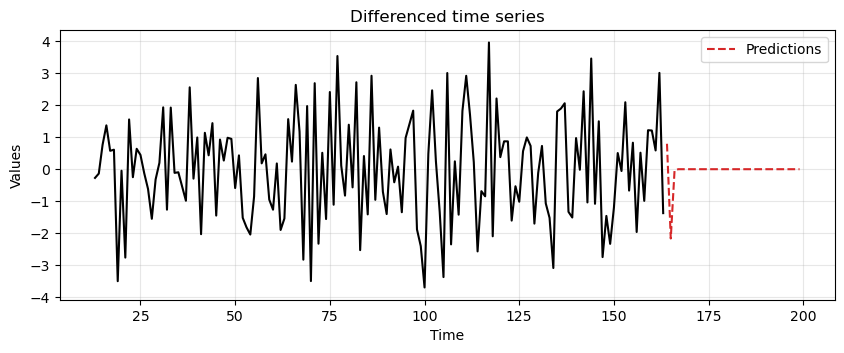

In [40]:
# Fit the model
model = ARIMA(diff_diff_ma, order=(0,0,3))
model_fit = model.fit()

# Compute predictions
diff_preds = model_fit.forecast(steps=len(test_data_ma))

ax = run_sequence_plot(time[13:len(train_data_ma)], diff_diff_ma, "")
ax.plot(time[len(train_data_ma):], diff_preds, label='Predictions', linestyle='--', color='tab:red')
plt.title('Differenced time series')
plt.legend();

- Then, we revert the two differencing operations to obtain the final predictions.

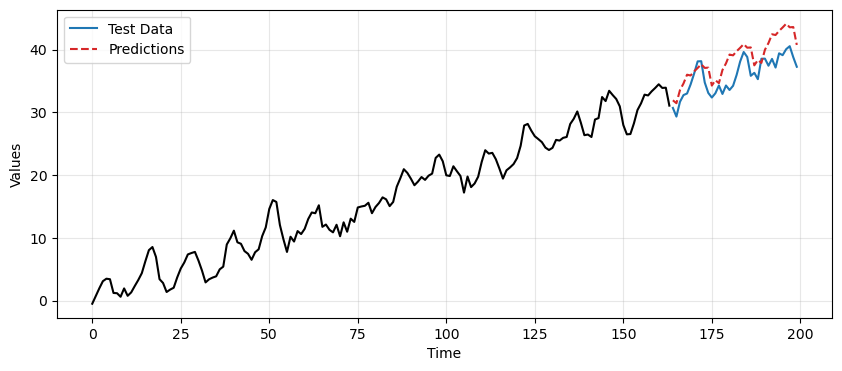

In [41]:
# Reintegrating the seasonal differencing
reintegrated_seasonal = np.zeros(len(test_data_ma))
reintegrated_seasonal[:12] = diff_ma[-12:] + diff_preds[:12]
for i in range(12, len(test_data_ma)):
    reintegrated_seasonal[i] = reintegrated_seasonal[i-12] + diff_preds[i]

# Reintegrating 1st order differencing
reintegrated = reintegrated_seasonal.cumsum() + train_data_ma[-1]

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time[:len(train_data_ma)], train_data_ma, "", ax=ax)
ax.plot(time[len(train_data_ma):], test_data_ma, label='Test Data', color='tab:blue')
ax.plot(time[len(train_data_ma):], reintegrated, label='Predictions', linestyle='--', color='tab:red')
plt.legend();

**TES-based approach**

- This time we fit the MA model with `tes_resid_ma` data and compute the predictions.

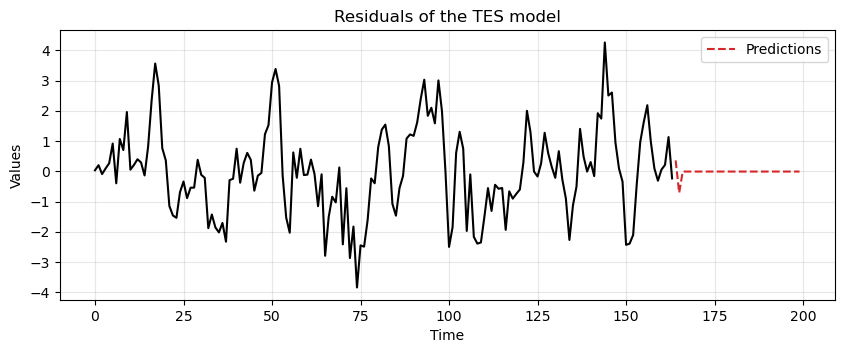

In [42]:
model = ARIMA(tes_resid_ma, order=(0,0,2))
model_fit = model.fit() # Fit the model

resid_preds = model_fit.forecast(steps=len(test_data_ma)) # Compute predictions

ax = run_sequence_plot(time[:len(train_data_ma)], tes_resid_ma, "")
ax.plot(time[len(train_data_ma):], resid_preds, label='Predictions', linestyle='--', color='tab:red')
plt.title('Residuals of the TES model')
plt.legend();

- The final predictions are obtained by combining:
    - the predictions of the residuals from the MA model,
    - the prediction of the trend and seasonality from the TES model.

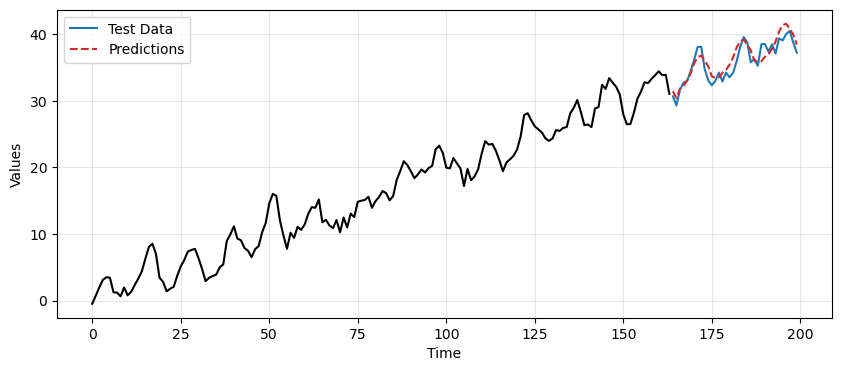

In [43]:
# Add back trend and seasonality to the predictions
tes_pred = tes_ma.forecast(len(test_data_ma))
final_preds = tes_pred + resid_preds

_, ax = plt.subplots(1, 1, figsize=(10, 4))
run_sequence_plot(time[:len(train_data_ma)], train_data_ma, "", ax=ax)
ax.plot(time[len(train_data_ma):], test_data_ma, label='Test Data', color='tab:blue')
ax.plot(time[len(train_data_ma):], final_preds, label='Predictions', linestyle='--', color='tab:red')
plt.legend();

- This time the differencing approach gives better results but still worse than the TES-based approach.

In [44]:
mse_differencing = mean_squared_error(test_data_ma, reintegrated)
mse_tes = mean_squared_error(test_data_ma, final_preds)

print(f"MSE of differencing: {mse_differencing:.2f}")
print(f"MSE of TES: {mse_tes:.2f}")

MSE of differencing: 9.49
MSE of TES: 1.69


---

## Summary

### AR vs MA Models

| **AR Models** | **MA Models** |
|:--------------|:--------------|
|Depend on past values of the series. | Depend on past forecast errors. |
| Suitable when past values have a direct influence on future values and for slowly changing time series | Useful when the series is better explained by shocks or random disturbances, i.e., time series with sudden changes|
| If the **PACF** drops sharply at a given lag $p$ or the first lag autocorrelation is **positive**, then use an **AR** model with order $p$| If the **ACF** drops sharply at a given lag $q$ or the first lag autocorrelation is **negative**, then use an **MA** model with order $q$ |

In this lecture you should have learned the basics of: 

1. The Autocorrelation Function (ACF).
2. The Partial Autocorrelation Function (PACF).
3. Autoregressive (AR) models.
4. Choosing order $q$.
5. Moving Average (MA) models.
6. Choosing order $p$. 
7. Combining smoothers to predict trend and seasonality with AR/MA models to predict the resuals.

---

## Exercises

- Load the two time series `arma_ts1` and `arma_ts2` by running the code below.

In [45]:
# Load the first time series
response = requests.get("https://zenodo.org/records/10951538/files/arma_ts3.npz?download=1")
response.raise_for_status()
arma_ts1 = np.load(BytesIO(response.content))['signal']
print(len(arma_ts1))

# Load the second time series
response = requests.get("https://zenodo.org/records/10951538/files/arma_ts4.npz?download=1")
response.raise_for_status()
arma_ts2 = np.load(BytesIO(response.content))['signal']
print(len(arma_ts2))

479
1000


For each time series

1. Split the time series in train and test.
    - Use the last 30 values as test for the first time series 
    - Use the last 100 as test for the second time series.
2. Make the time series stationary.
3. Determine the order $p$ of an AR model.
4. Compute the prediction of the test data with the AR($p$) model.
5. Determine the order $q$ of a MA model.
6. Compute the prediction of the test data with the MA($q$) model.